In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import joblib

import math
import json
from pathlib import Path
import kagglehub
import os
import shutil
from datetime import datetime

from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import PowerTransformer, LabelEncoder

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)

import shap



import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 42

In [3]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)

In [ ]:
dataset_identifier = "zeel8200/fraud-detection"  
input_data_folder = "input_data"  
extract_dir = os.path.join(os.getcwd(), input_data_folder) 

path = kagglehub.dataset_download(dataset_identifier)

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)


for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):  # Ensure it's a file
        shutil.copy(full_file_name, extract_dir)

print(f"The extracted files are:")
for file_name in os.listdir(extract_dir):
    print(f"- {file_name}")

The extracted files are:
- fraudTrain.csv
- fraudTest.csv


In [5]:
csv_files = ['fraudTrain.csv','fraudTest.csv']
train_files = ['fraudTrain.csv']
test_files = ['fraudTest.csv']

In [ ]:
dataframes = []

for file in csv_files:
    df = pd.read_csv(Path(extract_dir) / file)
    print(f"Shape of {file}: {df.shape}")
    df['source_file'] = file  
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

print("-" * 40)
print(f"Shape of combined dataframe df: {df.shape}")
print("-" * 40)

Shape of fraudTrain.csv: (1296675, 23)
Shape of fraudTest.csv: (555719, 23)
----------------------------------------
Shape of combined dataframe df: (1852394, 24)
----------------------------------------


In [7]:
df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,fraudTrain.csv
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,fraudTrain.csv


In [8]:
df.tail(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
1852392,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,fraudTest.csv
1852393,555718,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0,fraudTest.csv


In [9]:
df.sample(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
1280259,1280259,2020-06-15 11:20:43,6011724471098086,fraud_Kuhic Inc,grocery_pos,242.37,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,86a272a6bdbcba189c867596aa068314,1371295243,46.267536,-118.657094,0,fraudTrain.csv
26278,26278,2019-01-15 22:10:20,6011652924285713,fraud_Kub PLC,personal_care,4.26,Kathryn,Smith,F,19838 Tonya Prairie Apt. 947,Rocky Mount,MO,65072,38.2911,-92.7059,1847,Tax inspector,1988-10-26,e017253ab7f821a59fdd3898f228e3df,1326665420,39.059925,-92.453328,0,fraudTrain.csv


In [10]:
df.shape

(1852394, 24)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1852394.0,5.371934e+05,3.669110e+05,0.000000e+00,2.315490e+05,4.630980e+05,8.335758e+05,1.296674e+06
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01


In [13]:
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
source_file              0
dtype: int64

In [ ]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of duplicated rows: 0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [16]:
# Check for Mixed Data Types:
for col in df.columns:
    print(f"{col}: {df[col].apply(type).nunique()} unique types")

Unnamed: 0: 1 unique types
trans_date_trans_time: 1 unique types
cc_num: 1 unique types
merchant: 1 unique types
category: 1 unique types
amt: 1 unique types
first: 1 unique types
last: 1 unique types
gender: 1 unique types
street: 1 unique types
city: 1 unique types
state: 1 unique types
zip: 1 unique types
lat: 1 unique types
long: 1 unique types
city_pop: 1 unique types
job: 1 unique types
dob: 1 unique types
trans_num: 1 unique types
unix_time: 1 unique types
merch_lat: 1 unique types
merch_long: 1 unique types
is_fraud: 1 unique types
source_file: 1 unique types


In [ ]:
for col in df.select_dtypes(exclude=['object']):
    if df[col].nunique() == 1:
        print(f"Column '{col}' has a single unique value.")
    else:
        print(f"Column '{col}' has {df[col].nunique()} unique values.")

Column 'Unnamed: 0' has 1296675 unique values.
Column 'cc_num' has 999 unique values.
Column 'amt' has 60616 unique values.
Column 'zip' has 985 unique values.
Column 'lat' has 983 unique values.
Column 'long' has 983 unique values.
Column 'city_pop' has 891 unique values.
Column 'unix_time' has 1819583 unique values.
Column 'merch_lat' has 1754157 unique values.
Column 'merch_long' has 1809753 unique values.
Column 'is_fraud' has 2 unique values.


In [18]:
df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
source_file                    2
dtype: int64

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1852394.0,5.371934e+05,3.669110e+05,0.000000e+00,2.315490e+05,4.630980e+05,8.335758e+05,1.296674e+06
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01


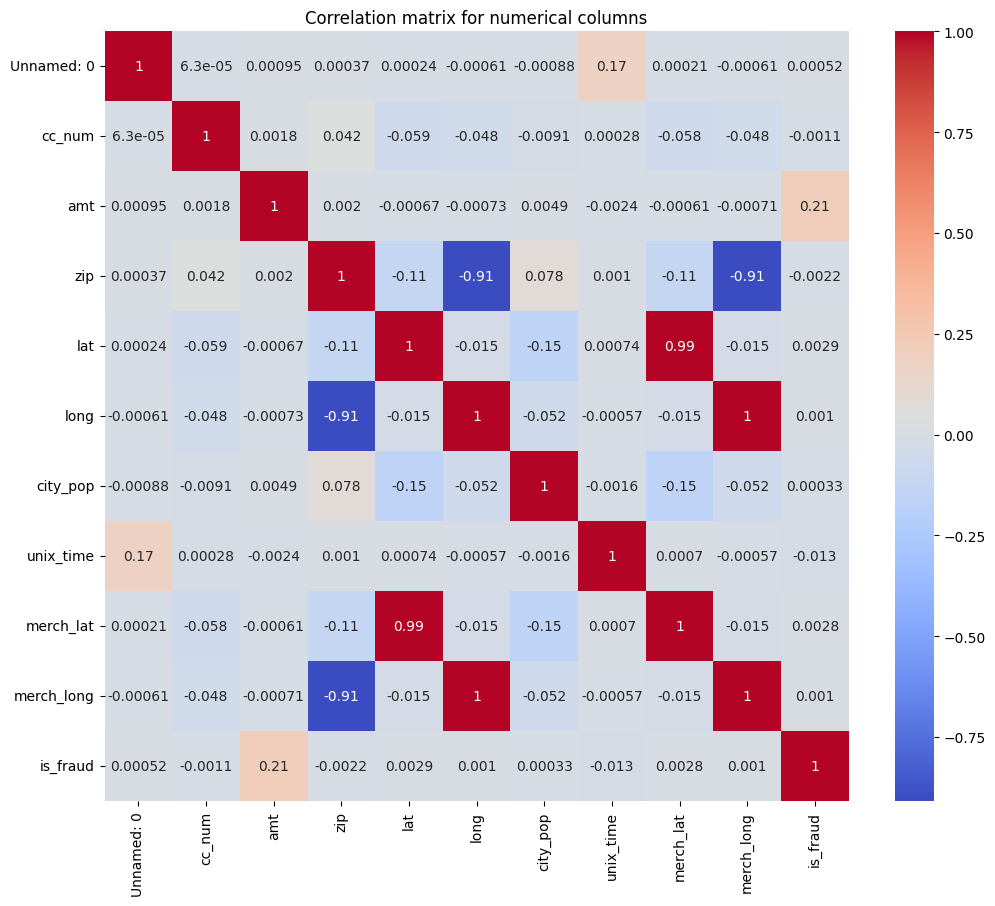

In [ ]:
df_numerical = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation matrix for numerical columns")
plt.show()

##### 3.6) Check Categories in Categorical Columns 

In [21]:
for col in df.select_dtypes(include='object'):
    print(f"Number of unique values in column '{col}': {df[col].nunique()}")
    #print(f"Categories in column '{col}': {df[col].unique()} \n")

Number of unique values in column 'trans_date_trans_time': 1819551
Number of unique values in column 'merchant': 693
Number of unique values in column 'category': 14
Number of unique values in column 'first': 355
Number of unique values in column 'last': 486
Number of unique values in column 'gender': 2
Number of unique values in column 'street': 999
Number of unique values in column 'city': 906
Number of unique values in column 'state': 51
Number of unique values in column 'job': 497
Number of unique values in column 'dob': 984
Number of unique values in column 'trans_num': 1852394
Number of unique values in column 'source_file': 2


Class Distribution (%):
is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64


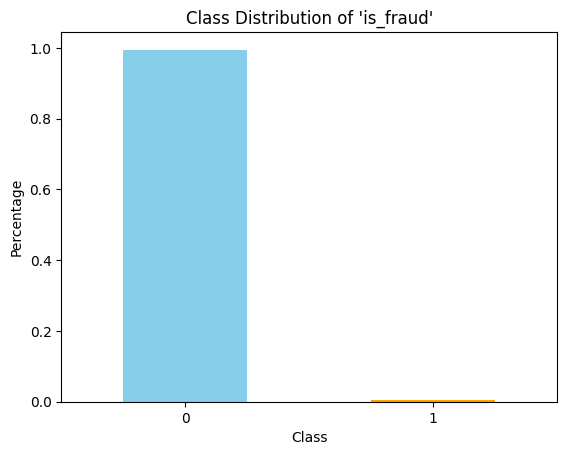

In [ ]:
class_distribution = df['is_fraud'].value_counts(normalize=True)

print("Class Distribution (%):")
print(class_distribution * 100)

class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution of 'is_fraud'")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

In [23]:
df_eda = df.copy()
df_eda.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,fraudTrain.csv


In [ ]:
df_eda['trans_date_trans_time'] = pd.to_datetime(df_eda['trans_date_trans_time'])

df_eda['transaction_hour'] = df_eda['trans_date_trans_time'].dt.hour

df_eda['day_of_week'] = df_eda['trans_date_trans_time'].dt.day_name()  # Keep only weekday names

df_eda['transaction_month'] = df_eda['trans_date_trans_time'].dt.month

def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour or hour < 5:
        return 'Night'

df_eda['part_of_day'] = df_eda['transaction_hour'].apply(categorize_part_of_day)

df_eda['is_weekend'] = df_eda['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

df_eda[['transaction_hour', 'day_of_week', 'transaction_month', 'part_of_day', 'is_weekend']].head()


,transaction_hour,day_of_week,transaction_month,part_of_day,is_weekend
0,0,Tuesday,1,Night,0
1,0,Tuesday,1,Night,0
2,0,Tuesday,1,Night,0
3,0,Tuesday,1,Night,0
4,0,Tuesday,1,Night,0


In [ ]:
df_eda['dob'] = pd.to_datetime(df_eda['dob'], errors='coerce')

reference_date = datetime(2020, 12, 31)  # Set the reference date to 31st December 2020
df_eda['age'] = (reference_date - df_eda['dob']).dt.days // 365  # Convert days to years

df_eda['age'].describe()

count    1.852394e+06
mean     4.675016e+01
std      1.740332e+01
min      1.500000e+01
25%      3.300000e+01
50%      4.500000e+01
75%      5.800000e+01
max      9.600000e+01
Name: age, dtype: float64

In [ ]:
def categorize_age_group(age):
    if age <= 12:
        return 'Child'
    elif 13 <= age <= 17:
        return 'Teenager'
    elif 18 <= age <= 25:
        return 'Young Adult'
    elif 26 <= age <= 40:
        return 'Adult'
    elif 41 <= age <= 60:
        return 'Middle-Aged'
    elif 61 <= age <= 80:
        return 'Senior'
    else:
        return 'Elderly'

df_eda['age_group'] = df_eda['age'].apply(categorize_age_group)

# Display the new 'age_group' column
df_eda[['age', 'age_group']].head()


,age,age_group
0,32,Adult
1,42,Middle-Aged
2,58,Middle-Aged
3,54,Middle-Aged
4,34,Adult


In [ ]:
def calculate_distance(X, lat_col, long_col, merch_lat_col, merch_long_col, new_column):
   
    X = X.copy()
    
    lat1 = np.radians(X[lat_col])
    lon1 = np.radians(X[long_col])
    lat2 = np.radians(X[merch_lat_col])
    lon2 = np.radians(X[merch_long_col])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371  
    X[new_column] = R * c
    return X



In [ ]:
df_eda = calculate_distance(df_eda, 'lat', 'long', 'merch_lat', 'merch_long', 'distance')

df_eda[['lat', 'long', 'merch_lat', 'merch_long', 'distance']].head()

,lat,long,merch_lat,merch_long,distance
0,36.0788,-81.1781,36.011293,-82.048315,78.597568
1,48.8878,-118.2105,49.159047,-118.186462,30.212176
2,42.1808,-112.2620,43.150704,-112.154481,108.206083
3,46.2306,-112.1138,47.034331,-112.561071,95.673231
4,38.4207,-79.4629,38.674999,-78.632459,77.556744


In [29]:
df_eda['distance'].describe()

count    1.852394e+06
mean     7.611173e+01
std      2.911697e+01
min      2.225452e-02
25%      5.532009e+01
50%      7.821638e+01
75%      9.850947e+01
max      1.521172e+02
Name: distance, dtype: float64

In [ ]:
city_pop_bins = [0, 10000, 50000, 100000, 500000, 1000000, np.inf]
city_pop_labels = ['<10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '>1M']

df_eda['city_pop_bin'] = pd.cut(df_eda['city_pop'], bins=city_pop_bins, labels=city_pop_labels)

In [ ]:
columns_to_remove = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant',
        'first', 'last',  'street', 'city', 'state', 'zip',
       'lat', 'long',  'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long'
]

df_eda.drop(columns=columns_to_remove, inplace=True)

In [32]:
df_eda.columns

Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'source_file',
       'transaction_hour', 'day_of_week', 'transaction_month', 'part_of_day',
       'is_weekend', 'age', 'age_group', 'distance', 'city_pop_bin'],
      dtype='object')

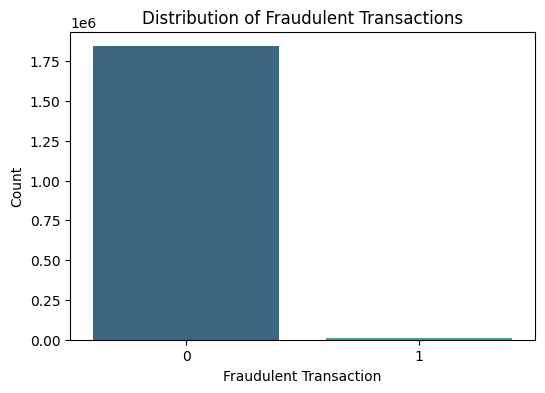

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_eda, palette='viridis')
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Count')
plt.show()

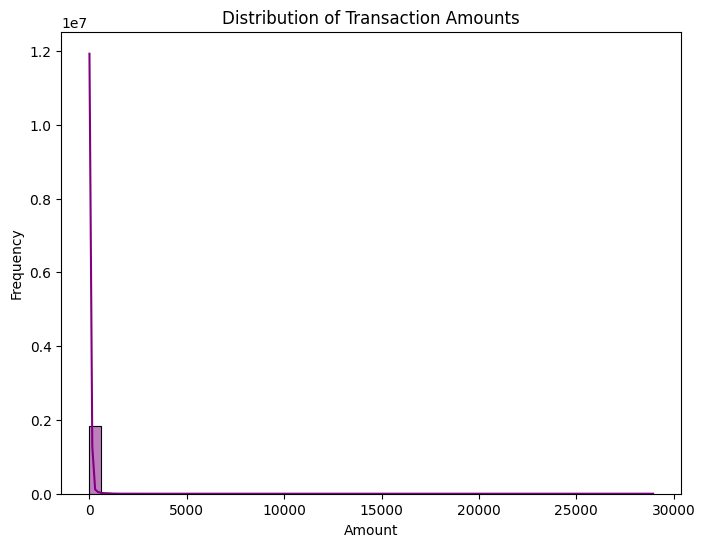

In [34]:
# Plot the distribution of the transaction amount
plt.figure(figsize=(8, 6))
sns.histplot(df_eda['amt'], kde=True, color='purple', bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

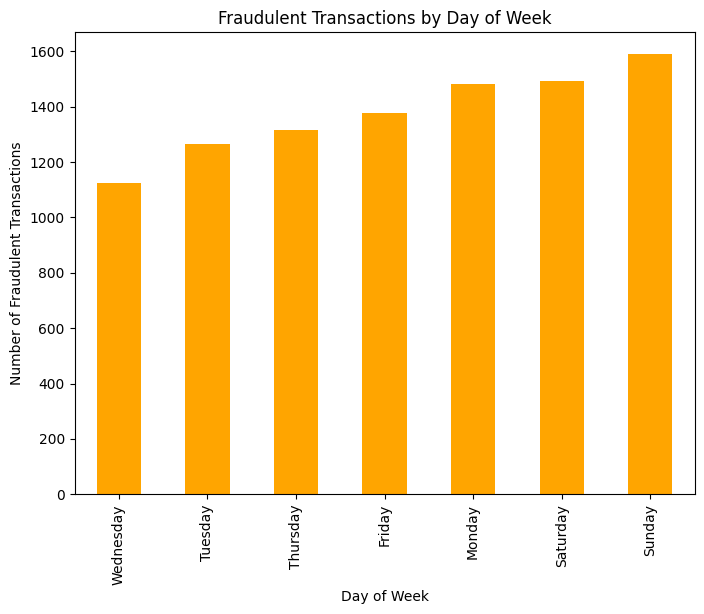

In [ ]:
fraud_by_day = df_eda.groupby('day_of_week')['is_fraud'].sum()

plt.figure(figsize=(8, 6))
fraud_by_day.sort_values().plot(kind='bar', color='orange')
plt.title('Fraudulent Transactions by Day')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

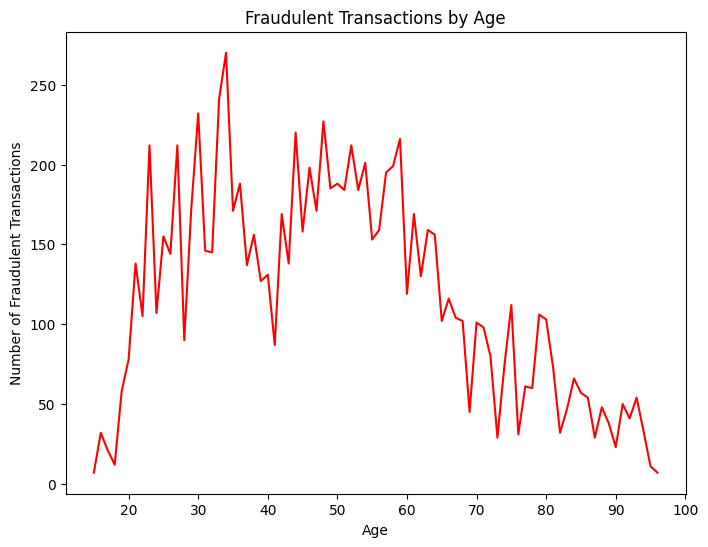

In [ ]:
fraud_by_age = df_eda.groupby('age')['is_fraud'].sum()

plt.figure(figsize=(8, 6))
fraud_by_age.plot(kind='line', color='red')
plt.title('Fraudulent Transactions by Age')
plt.xlabel('Age')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

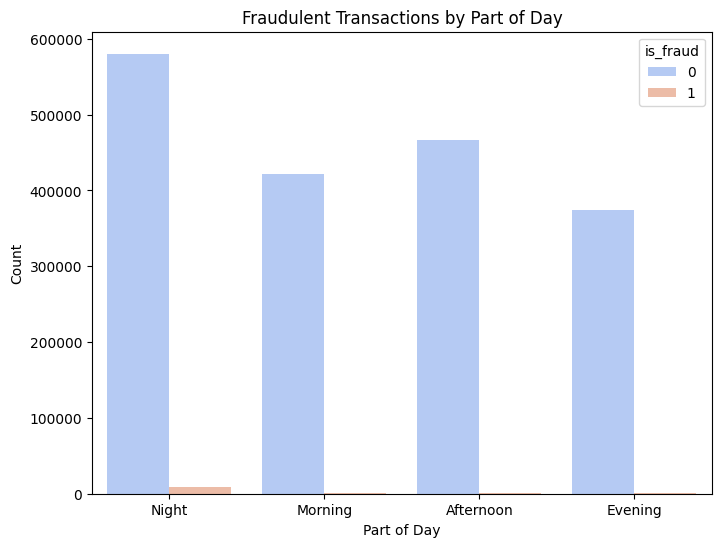

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='part_of_day', hue='is_fraud', data=df_eda, palette='coolwarm')
plt.title('Fraudulent Transactions by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

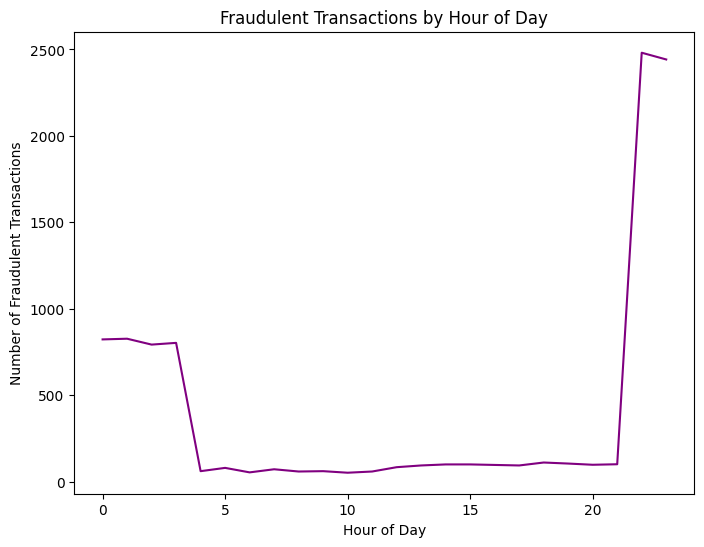

In [ ]:
fraud_by_hour = df_eda.groupby('transaction_hour')['is_fraud'].sum()

plt.figure(figsize=(8, 6))
fraud_by_hour.plot(kind='line', color='purple')
plt.title('Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

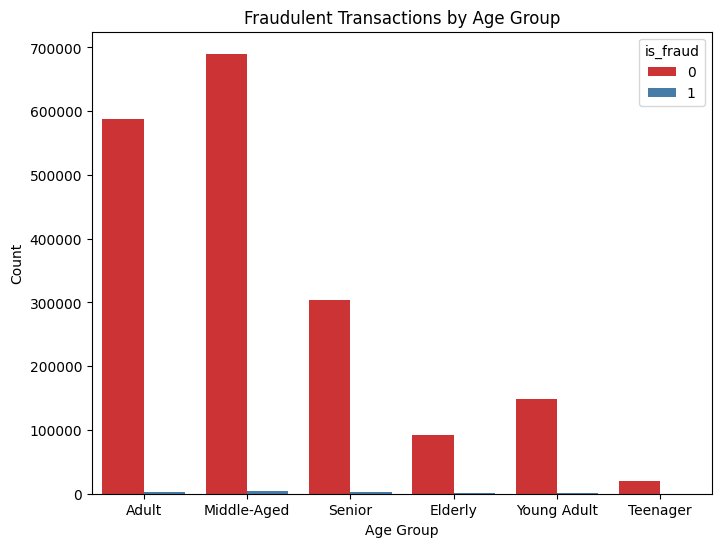

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age_group', hue='is_fraud', data=df_eda, palette='Set1')
plt.title('Fraudulent Transactions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

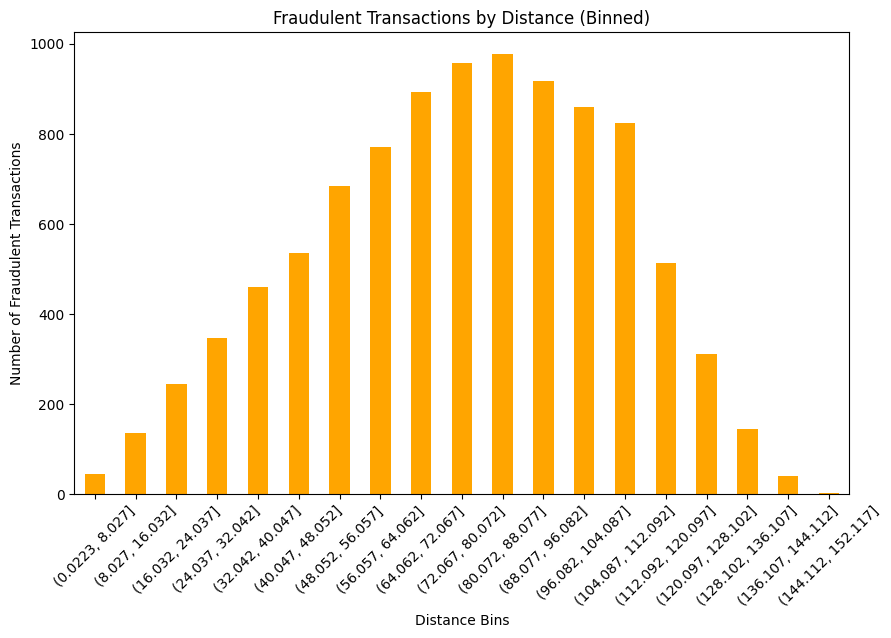

In [ ]:
distance_bins = np.linspace(df_eda['distance'].min(), df_eda['distance'].max(), num=20)
# Bin the 'distance' column
df_eda['distance_bin'] = pd.cut(df_eda['distance'], bins=distance_bins)

fraud_by_distance_bin = df_eda.groupby('distance_bin')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(10, 6))
fraud_by_distance_bin.plot(kind='bar', color='orange')
plt.title('Fraudulent Transactions by Distance (Binned)')
plt.xlabel('Distance Bins')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

In [43]:
# define numerical & categorical columns
numerical_features = [
    feature for feature in df_eda.columns 
    if pd.api.types.is_numeric_dtype(df_eda[feature]) and feature != "is_fraud"
]

discrete_numerical_features = [feature for feature in numerical_features if df_eda[feature].nunique() < 25]

continuous_numerical_features = [feature for feature in numerical_features if df_eda[feature].nunique() >= 25]

categorical_features = [feature for feature in df_eda.columns if df_eda[feature].dtype == 'object']

target_column = "is_fraud"

# print column names
print(f'There are {len(numerical_features)} numerical features : {numerical_features}')
print(f'\nThere are {len(discrete_numerical_features)} discrete numerical features : {discrete_numerical_features}')
print(f'\nThere are {len(continuous_numerical_features)} continuos numerical features : {continuous_numerical_features}')
print(f'\nThere are {len(categorical_features)} categorical features : {categorical_features}')

There are 7 numerical features : ['amt', 'city_pop', 'transaction_hour', 'transaction_month', 'is_weekend', 'age', 'distance']

There are 3 discrete numerical features : ['transaction_hour', 'transaction_month', 'is_weekend']

There are 4 continuos numerical features : ['amt', 'city_pop', 'age', 'distance']

There are 6 categorical features : ['category', 'gender', 'source_file', 'day_of_week', 'part_of_day', 'age_group']


In [44]:
df_eda['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1852394 entries, 0 to 1852393
Series name: age
Non-Null Count    Dtype
--------------    -----
1852394 non-null  int64
dtypes: int64(1)
memory usage: 14.1 MB


In [48]:
# Check for Skewness in Numerical Columns
for feature in continuous_numerical_features:
    skewness = df_eda[feature].skew()
    if abs(skewness) > 1:
        print(f"'{feature}' is highly skewed with skewness: {skewness:.2f}")

'amt' is highly skewed with skewness: 40.81
'city_pop' is highly skewed with skewness: 5.59


In [49]:
# Check for Multicollinearity
# Compute VIF for each numerical feature
X = df_eda[continuous_numerical_features]
X = add_constant(X)  # Add a constant column for VIF calculation
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Feature        VIF
0     const  15.587590
1       amt   1.000130
2  city_pop   1.008367
3       age   1.008353
4  distance   1.000131


In [ ]:
train_df = df[df['source_file'].isin(train_files)].drop(columns=['source_file'])

test_df = df[df['source_file'].isin(test_files)].drop(columns=['source_file'])

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (1296675, 23)
Test data shape: (555719, 23)


In [52]:
test_df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296675,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1296676,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0


In [ ]:
X_train_raw = train_df.drop(columns=target_column, axis=1)

y_train = train_df[target_column]

X_test_raw = test_df.drop(columns=target_column, axis=1)

y_test = test_df[target_column]

print(f"Shape of X_train_raw: {X_train_raw.shape}")
print(f"Shape of X_test_raw: {X_test_raw.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_raw: (1296675, 22)
Shape of X_test_raw: (555719, 22)
Shape of y_train: (1296675,)
Shape of y_test: (555719,)


In [ ]:
class ChangeDataType(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = pd.to_datetime(X[col], errors='coerce')
        return X

class DateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_column, transaction_hour_bins, transaction_hour_labels):
        self.date_column = date_column
        self.transaction_hour_bins = transaction_hour_bins
        self.transaction_hour_labels = transaction_hour_labels
        self.new_columns = ['transaction_hour', 'transaction_month', 'is_weekend', 'day_of_week', 'part_of_day']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['transaction_hour'] = X[self.date_column].dt.hour
        X['transaction_month'] = X[self.date_column].dt.month
        X['is_weekend'] = X[self.date_column].dt.weekday.isin([5, 6]).astype(int)
        
        # Day of week: Monday=0, Sunday=6
        X['day_of_week'] = X[self.date_column].dt.day_name()
        
        # Part of day classification
        X['part_of_day'] = pd.cut(X['transaction_hour'], 
                                  bins=self.transaction_hour_bins, 
                                  labels=self.transaction_hour_labels, 
                                  right=True)
        return X


class AgeFeature(BaseEstimator, TransformerMixin):
    def __init__(self, dob_column):
        self.dob_column = dob_column
        self.new_column = 'age'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        reference_date = pd.Timestamp(2020, 12, 31)
        X[self.new_column] = (reference_date - X[self.dob_column]).dt.days // 365
        return X
    
class CalculateDistance(BaseEstimator, TransformerMixin):
    def __init__(self, lat_col, long_col, merch_lat_col, merch_long_col):
        self.lat_col = lat_col
        self.long_col = long_col
        self.merch_lat_col = merch_lat_col
        self.merch_long_col = merch_long_col
        self.new_column = 'distance'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        lat1 = np.radians(X[self.lat_col])
        lon1 = np.radians(X[self.long_col])
        lat2 = np.radians(X[self.merch_lat_col])
        lon2 = np.radians(X[self.merch_long_col])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        R = 6371 
        X[self.new_column] = R * c  
        return X

class BinCityPopulation(BaseEstimator, TransformerMixin):
    def __init__(self, city_pop_bins, city_pop_labels):
        self.city_pop_bins = city_pop_bins
        self.city_pop_labels = city_pop_labels
        self.new_column = 'city_pop_bin'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_column] = pd.cut(X['city_pop'], bins=self.city_pop_bins, labels=self.city_pop_labels)
        return X

class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer = PowerTransformer(method='yeo-johnson')
        self.new_column = 'amt_yeo_johnson'

    def fit(self, X, y=None):
        self.transformer.fit(X[['amt']])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_column] = self.transformer.transform(X[['amt']])
        return X


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(columns=self.columns, errors='ignore')
        self.remaining_columns = X.columns
        return X
        

class LabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = self.label_encoders[col].transform(X[col])
        return X

class ScaleFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X = X.copy()
        X[:] = self.scaler.transform(X)
        return X

In [ ]:
city_pop_bins = [0, 10000, 50000, 100000, 500000, 1000000, np.inf]
city_pop_labels = ['<10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '>1M']

transaction_hour_bins=[-1, 5, 11, 17, 21, 24]
transaction_hour_labels=['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'amt', 
                'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 
                'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']

categorical_features = ['category', 'gender', 'day_of_week', 'part_of_day', 'city_pop_bin']

preprocessor = Pipeline([
    ('change_dtype', ChangeDataType(columns=['trans_date_trans_time', 'dob'])),
    ('datetime_features', DateTimeFeatures(date_column='trans_date_trans_time',
                                           transaction_hour_bins = transaction_hour_bins,
                                           transaction_hour_labels = transaction_hour_labels)),
    ('age_feature', AgeFeature(dob_column='dob')),
    ('calculate_distance', CalculateDistance(lat_col='lat', long_col='long', 
                                             merch_lat_col='merch_lat', merch_long_col='merch_long')),
    ('bin_city_pop', BinCityPopulation(city_pop_bins = city_pop_bins, city_pop_labels = city_pop_labels)),
    ('yeo_johnson', YeoJohnsonTransformer()),
    ('drop_columns', DropColumns(columns=drop_columns)),
    ('label_encoding', LabelEncoding(columns=categorical_features)),
    ('scale_features', ScaleFeatures()),
])

In [ ]:
train_preprocessed = preprocessor.fit_transform(X_train_raw)
train_preprocessed[target_column] = y_train.values
train_preprocessed.head(2)

,category,gender,transaction_hour,transaction_month,is_weekend,day_of_week,part_of_day,age,distance,city_pop_bin,amt_yeo_johnson,is_fraud
0,0.615385,0,0.0,0.0,0,0.833333,0.5,0.209877,0.516620,0.8,0.073333,0
1,0.307692,0,0.0,0.0,0,0.833333,0.5,0.333333,0.198494,0.8,0.309368,0


In [ ]:
test_preprocessed = preprocessor.transform(X_test_raw)
test_preprocessed[target_column] = y_test.values
test_preprocessed.sample(2)

,category,gender,transaction_hour,transaction_month,is_weekend,day_of_week,part_of_day,age,distance,city_pop_bin,amt_yeo_johnson,is_fraud
1835321,0.615385,0,0.391304,1.000000,0,0.166667,0.75,0.555556,0.646212,0.8,0.118747,0
1583310,0.153846,0,0.391304,0.818182,0,0.833333,0.75,0.012346,0.749983,0.8,0.281770,0


In [ ]:
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [ ]:
preprocessor_loaded = joblib.load('preprocessor.joblib')

In [ ]:
class SMOTESampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = SMOTE(random_state=random_state)

    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


class ADASYN_Sampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = ADASYN(random_state=random_state)

    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


class TomekLinksSampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = TomekLinks()

    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


class SMOTETomekSampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = SMOTETomek(random_state=random_state)

    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})

In [ ]:
smote_sampler = SMOTESampler(target_column=target_column)
smote_resampled_df = smote_sampler.fit_resample(train_preprocessed)
print(f"SMOTE completed")

adasyn_sampler = ADASYN_Sampler(target_column=target_column)
adasyn_resampled_df = adasyn_sampler.fit_resample(train_preprocessed)
print(f"ADASYN completed")


print(smote_resampled_df[target_column].value_counts())
print(adasyn_resampled_df[target_column].value_counts())

SMOTE completed
ADASYN completed
is_fraud
0    1289169
1    1289169
Name: count, dtype: int64
is_fraud
1    1289977
0    1289169
Name: count, dtype: int64


In [ ]:
base_models_classification = {
    "logistic_regression": LogisticRegression(random_state=random_state),
    "decision_tree": DecisionTreeClassifier(random_state=random_state),
}

In [ ]:
datasets = {
    "SMOTE": smote_resampled_df,
    "ADASYN": adasyn_resampled_df,
}

In [ ]:
def cross_validate_models(train_data, target_column='is_fraud', base_models=base_models_classification, metric="f1", cv=None):
    """
    Perform cross-validation for each model and return a DataFrame with the scores.
    
    Parameters:
    - train_data: DataFrame containing the features and the target column.
    - target_column: The column name that contains the target variable.
    - base_models: Dictionary containing the models to evaluate.
    - metric: Scoring metric for evaluation, default is "f1".
    - cv: Cross-validation strategy, default is StratifiedKFold.
    
    Returns:
    - DataFrame with model names and their respective cross-validation scores.
    """
    X_train = train_data.drop(columns=[target_column]) 
    y_train = train_data[target_column]  
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    results = []
    
    scoring_metrics = {
        "f1": make_scorer(f1_score),
        "roc_auc": make_scorer(roc_auc_score)
    }
    
    if metric not in scoring_metrics:
        raise ValueError(f"Invalid metric: {metric}. Available metrics: {', '.join(scoring_metrics.keys())}")
    
    scorer = scoring_metrics[metric]
    
    for model_name, model in base_models.items():
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
        for score in scores:
            results.append({"Model": model_name, f"{metric.capitalize()} Score": score})
    
    return pd.DataFrame(results)

In [ ]:
def plot_f1_boxplot(df):
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Model", y="F1 Score", data=df)
    plt.title("F1 Score Box plot")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [67]:
all_cv_results

{'SMOTE':                  Model  F1 Score
 0  logistic_regression  0.789755
 1  logistic_regression  0.789789
 2  logistic_regression  0.789966
 3  logistic_regression  0.789885
 4  logistic_regression  0.789410
 5        decision_tree  0.997833
 6        decision_tree  0.997996
 7        decision_tree  0.997866
 8        decision_tree  0.998040
 9        decision_tree  0.997945,
 'ADASYN':                  Model  F1 Score
 0  logistic_regression  0.720215
 1  logistic_regression  0.721876
 2  logistic_regression  0.721025
 3  logistic_regression  0.721382
 4  logistic_regression  0.721302
 5        decision_tree  0.997906
 6        decision_tree  0.997925
 7        decision_tree  0.997923
 8        decision_tree  0.997989
 9        decision_tree  0.997899}

In [ ]:
def evaluate_classification_models(X_train, y_train, X_test, y_test, base_models):
    
    report = {}

    for model_name, model in base_models.items():
        
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_precision_pos_class = precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_precision_pos_class = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        train_recall_pos_class = recall_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_recall_pos_class = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        train_f1_pos_class = f1_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_f1_pos_class = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        test_classification_report = classification_report(y_test, y_test_pred, zero_division=0)
        test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

        report[model_name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision_pos_class': train_precision_pos_class,
            'test_precision_pos_class': test_precision_pos_class,
            'train_recall_pos_class': train_recall_pos_class,
            'test_recall_pos_class': test_recall_pos_class,
            'train_f1_pos_class': train_f1_pos_class,
            'test_f1_pos_class': test_f1_pos_class,
            'test_classification_report': test_classification_report,
            'test_confusion_matrix': test_confusion_matrix.tolist()  # Convert to list for better readability
        }

    return report

In [ ]:
all_base_model_results = {}

X_test = test_preprocessed.drop(columns=[target_column], axis= 'columns')
y_test = test_preprocessed[target_column]

for dataset_name, dataset in datasets.items():
    X_train = dataset.drop(columns=[target_column], axis= 'columns')
    y_train = dataset[target_column]

    base_model_result = evaluate_classification_models(X_train, y_train, X_test, y_test, base_models_classification)
    print(f"{dataset_name} completed")
    all_base_model_results[dataset_name] = base_model_result

SMOTE completed
ADASYN completed


In [ ]:
def print_results_nicely(results_dict):
    """
    Print the results from all_base_model_results in a structured format.
    
    Args:
        results_dict: Dictionary with dataset names as keys and evaluation results as values.
    """
    for dataset_name, model_results in results_dict.items():
        print(f"\nResults for Dataset: {dataset_name}")
        print("-" * 50)
        
        results_df = pd.DataFrame(model_results).T.reset_index()
        results_df.rename(columns={'index': 'Model'}, inplace=True)
        
        print(results_df.to_string(index=False))  # Print without row indices
        print("-" * 50)

print_results_nicely(all_base_model_results)


Results for Dataset: SMOTE
--------------------------------------------------
              Model train_accuracy test_accuracy train_precision_pos_class test_precision_pos_class train_recall_pos_class test_recall_pos_class train_f1_pos_class test_f1_pos_class                                                                                                                                                                                                                                                                                                                     test_classification_report          test_confusion_matrix
logistic_regression       0.790911      0.846503                  0.794155                 0.019029               0.785396                0.7669           0.789751          0.037137               precision    recall  f1-score   support\n\n           0       1.00      0.85      0.92    553574\n           1       0.02      0.77      0.04      2145\n\n    accuracy          

In [ ]:
with open('base_model_results_report.json', 'w') as json_file:
    json.dump(all_base_model_results, json_file, indent=4)

print("Base models report saved to 'base_model_results_report.json'")

all_base_model_results

Base models report saved to 'base_model_results_report.json'


{'SMOTE': {'logistic_regression': {'train_accuracy': 0.7909106563995877,
   'test_accuracy': 0.846503358711867,
   'train_precision_pos_class': 0.794155064904506,
   'test_precision_pos_class': 0.01902922055387178,
   'train_recall_pos_class': 0.7853958635368986,
   'test_recall_pos_class': 0.7668997668997669,
   'train_f1_pos_class': 0.7897511776949511,
   'test_f1_pos_class': 0.03713695522118499,
   'test_classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.85      0.92    553574\n           1       0.02      0.77      0.04      2145\n\n    accuracy                           0.85    555719\n   macro avg       0.51      0.81      0.48    555719\nweighted avg       1.00      0.85      0.91    555719\n',
   'test_confusion_matrix': [[468773, 84801], [500, 1645]]},
  'decision_tree': {'train_accuracy': 1.0,
   'test_accuracy': 0.9971424406939479,
   'train_precision_pos_class': 1.0,
   'test_precision_pos_class': 0.5960676095205

In [73]:
def find_best_model_and_dataset(
    results, 
    test_metric='test_f1_pos_class', 
    train_metric='train_f1_pos_class', 
    tolerance=0.1
):
    """
    Find the best model and dataset based on test metric and overfitting gap.
    Includes comprehensive logging for all models and sampling methods.

    Args:
        results: Nested dictionary with sampling methods, models, and evaluation metrics.
        test_metric: Metric to evaluate model performance on the test set.
        train_metric: Metric to evaluate model performance on the training set.
        tolerance: Percentage (as decimal) within which models are considered close to the best.

    Returns:
        best_sampling_method: Name of the sampling method with the best-performing model (or None).
        best_model: Name of the best-performing model (or None).
        best_metrics: Metrics of the best-performing model (or None).
    """
    # Step 1: Find the highest test_f1_score across all models
    max_test_score = -float('inf')
    for sampling_method, models in results.items():
        for model_name, metrics in models.items():
            max_test_score = max(max_test_score, metrics[test_metric])

    # Initialize variables for the best model selection
    best_sampling_method = None
    best_base_model = None
    smallest_gap = float('inf')

    # Step 2: Iterate through all models to log details and identify the best model
    for sampling_method, models in results.items():
        for model_name, metrics in models.items():
            train_score = metrics[train_metric]
            test_score = metrics[test_metric]
            overfitting_gap = train_score - test_score

            # Debugging: Log details for every model
            print(f"Dataset: {sampling_method}, Model: {model_name}, "
                  f"Train Score: {train_score:.4f}, Test Score: {test_score:.4f}, "
                  f"Overfitting Gap: {overfitting_gap:.4f}")

            # Check if the model falls within the tolerance range
            if test_score >= max_test_score * (1 - tolerance):
                # Select the model with the smallest overfitting gap
                if overfitting_gap < smallest_gap:
                    smallest_gap = overfitting_gap
                    best_sampling_method = sampling_method
                    best_base_model = model_name

    return best_sampling_method, best_base_model


# Example usage
best_sampling_method, best_base_model = find_best_model_and_dataset(
    results = all_base_model_results,
    test_metric='test_f1_pos_class',
    train_metric='train_f1_pos_class',
)
    
print(f"Best Sampling method: {best_sampling_method}")
print(f"Best Model: {best_base_model}")

Dataset: SMOTE, Model: logistic_regression, Train Score: 0.7898, Test Score: 0.0371, Overfitting Gap: 0.7526
Dataset: SMOTE, Model: decision_tree, Train Score: 1.0000, Test Score: 0.6852, Overfitting Gap: 0.3148
Dataset: ADASYN, Model: logistic_regression, Train Score: 0.7212, Test Score: 0.0244, Overfitting Gap: 0.6968
Dataset: ADASYN, Model: decision_tree, Train Score: 1.0000, Test Score: 0.6809, Overfitting Gap: 0.3191
Best Sampling method: SMOTE
Best Model: decision_tree


In [ ]:
params_grid = {
    "logistic_regression": {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "saga", "liblinear"],
        "max_iter": [100, 200, 500],
    },
    "svm": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"],
        "degree": [2, 3, 4],  
    },

    "decision_tree": {
        "criterion": ["gini", "entropy"],  
        "max_depth": [20, 30],  
        "min_samples_split": [2, 5], 
        "min_samples_leaf": [1, 2], 
        "max_features": ["sqrt"] 
    },

    "random_forest": {
        "n_estimators": [50, 100, 200],
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": [None, "sqrt", "log2"],
        "bootstrap": [True, False],
    },
    "gradient_boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.8, 1.0],
        "max_features": [None, "sqrt", "log2"],
    },
    "adaboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1],
        "algorithm": ["SAMME", "SAMME.R"],
        "base_estimator": [
            DecisionTreeClassifier(max_depth=1),
            DecisionTreeClassifier(max_depth=3),
        ],  
    },
    "xgboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1, 0.2],
    },
    "catboost": {
        "iterations": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5, 7],
        "border_count": [32, 64, 128],
        "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    },
}

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, models, params):
    
    report = {}  
    
    for model_name, model in models.items():
        try:
            param_grid = params[model_name]

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1,
                scoring='f1',  
            )
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            train_precision_pos_class = precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_precision_pos_class = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            train_recall_pos_class = recall_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_recall_pos_class = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            train_f1_pos_class = f1_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_f1_pos_class = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            test_classification_report = classification_report(y_test, y_test_pred, zero_division=0)
            test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

            report[model_name] = {
                'best_model': best_model,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_precision_pos_class': train_precision_pos_class,
                'test_precision_pos_class': test_precision_pos_class,
                'train_recall_pos_class': train_recall_pos_class,
                'test_recall_pos_class': test_recall_pos_class,
                'train_f1_pos_class': train_f1_pos_class,
                'test_f1_pos_class': test_f1_pos_class,
                'test_classification_report': test_classification_report,
                'test_confusion_matrix': test_confusion_matrix.tolist(),
                'best_params': grid_search.best_params_
            }

        except Exception as e:
            print(f"Error in model {model_name}: {e}")
                
    return report, best_model

In [ ]:
models = {best_base_model: base_models_classification[best_base_model]}   

X_train = datasets[best_sampling_method].drop(columns=[target_column], axis='columns')  
y_train = datasets[best_sampling_method][target_column]  

X_test = test_preprocessed.drop(columns=[target_column], axis='columns')  
y_test = test_preprocessed[target_column]  

tuned_model_report, tuned_model = hyperparameter_tuning(X_train, y_train, X_test, y_test, models, params_grid)

print(tuned_model_report)

{'decision_tree': {'best_model': DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, random_state=42), 'train_accuracy': 0.9988263757505804, 'test_accuracy': 0.9959817821596886, 'train_precision_pos_class': 0.9993492874386851, 'test_precision_pos_class': 0.48590647021140293, 'train_recall_pos_class': 0.9983027826452544, 'test_recall_pos_class': 0.7072261072261072, 'train_f1_pos_class': 0.9988257609270978, 'test_f1_pos_class': 0.5760394911714449, 'test_classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    553574\n           1       0.49      0.71      0.58      2145\n\n    accuracy                           1.00    555719\n   macro avg       0.74      0.85      0.79    555719\nweighted avg       1.00      1.00      1.00    555719\n', 'test_confusion_matrix': [[551969, 1605], [628, 1517]], 'best_params': {'criterion': 'gini', 'max_depth': 30, 'm

In [ ]:
def model_to_str(model):
    if hasattr(model, 'estimator'):  
        return f"{type(model).__name__}(estimator={type(model.estimator).__name__})"
    return str(type(model).__name__) 
serializable_report = {}

for model_name, metrics in tuned_model_report.items():
    serializable_report[model_name] = {
        'model_type': model_to_str(models[model_name]),  
        'train_accuracy': metrics['train_accuracy'],
        'test_accuracy': metrics['test_accuracy'],
        'train_precision_pos_class': metrics['train_precision_pos_class'],
        'test_precision_pos_class': metrics['test_precision_pos_class'],
        'train_recall_pos_class': metrics['train_recall_pos_class'],
        'test_recall_pos_class': metrics['test_recall_pos_class'],
        'train_f1_pos_class': metrics['train_f1_pos_class'],
        'test_f1_pos_class': metrics['test_f1_pos_class'],
        'test_classification_report': metrics['test_classification_report'],
        'test_confusion_matrix': metrics['test_confusion_matrix'],
        'best_params': metrics['best_params'],
    }


with open('tuned_model_report.json', 'w') as json_file:
    json.dump(serializable_report, json_file, indent=4)

print("Tuned model report saved to 'tuned_model_report.json'")

Tuned model report saved to 'tuned_model_report.json'


In [ ]:
explainer = shap.Explainer(tuned_model, X_test)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 1111116/1111438 [07:21<00:00]       

In [79]:
positive_class_index = 1

In [ ]:
redictions = tuned_model.predict_proba(X_test)

print(f"Class probabilities: {predictions[0]}")

Class probabilities: [1. 0.]


In [ ]:
user_data = {
    'Unnamed: 0': [None],  
    'trans_date_trans_time': ['2025-01-06 10:15:00'],  
    'cc_num': [None],  
    'merchant': [None],  
    'category': ['health_fitness'],  
    'amt': [250.75],  
    'first': [None],  
    'last': [None],  
    'gender': ['M'],  
    'street': [None],  
    'city': [None],  
    'state': [None],  
    'zip': [None],  
    'lat': [40.7128],  
    'long': [-74.0060],  
    'city_pop': [8419600],  
    'job': [None],  
    'dob': ['1990-01-01'],  
    'trans_num': [None],  
    'unix_time': [None],  
    'merch_lat': [40.7150],  
    'merch_long': [-74.0110]  
}

user_input_df = pd.DataFrame(user_data)

user_input_df_preprocessed = preprocessor_loaded.transform(user_input_df)

outcome = tuned_model.predict(user_input_df_preprocessed)[0]  # Get the single prediction
outcome_prob = tuned_model.predict_proba(user_input_df_preprocessed)[0]  # Get probabilities for the prediction

if outcome == 1:
    print("Transaction Status: Fraud")
else:
    print("Transaction Status: Normal Transaction")

print("Prediction Probabilities:")
print(f"Normal Transaction Probability: {outcome_prob[0]:.2%}")
print(f"Fraud Probability: {outcome_prob[1]:.2%}")

Transaction Status: Normal Transaction
Prediction Probabilities:
Normal Transaction Probability: 100.00%
Fraud Probability: 0.00%
